In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import anndata as ad
import csv
import gpzoo.pri_experiment_utilities as putil
import matplotlib.pyplot as plt
import numpy as np
import random
import scanpy as sc
import scipy.sparse as sparse
import squidpy as sq
import tensorflow as tf
import time
import torch
import torch.nn.utils as nn_utils

from anndata import AnnData
from contextlib import suppress
from copy import deepcopy
from gpzoo.gp import SVGP
from gpzoo.kernels import NSF_RBF
from gpzoo.likelihoods import NSF2
from gpzoo.utilities import (add_jitter, anndata_to_train_val, deviancePoisson, 
                       
dims_autocorr, regularized_nmf, rescale_spatial_coords, 
                             scanpy_sizefactors)
from os import path
from scanpy import read_h5ad
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.model_selection import ParameterGrid, KFold
from squidpy.gr import spatial_autocorr, spatial_neighbors
from tensorflow import constant
from tensorflow.data import Dataset
from torch import distributions, nn, optim
from tqdm.auto import tqdm

2024-08-14 04:02:56.502098: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-14 04:02:56.514974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 04:02:56.537080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 04:02:56.537137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 04:02:56.549333: I tensorflow/core/platform/cpu_feature_gua

In [3]:
print("CUDA available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())
print("Current GPU: ", torch.cuda.current_device())
print("GPU Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available:  True
Number of GPUs:  2
Current GPU:  0
GPU Name:  NVIDIA A30


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
random.seed(256)
root_path = '/engelhardt/home/pshrestha/vnngp/'
save_path = path.join(root_path, 'results/visium/nsf')

In [6]:
save_path

'/engelhardt/home/pshrestha/vnngp/results/visium/nsf'

In [7]:
X, Y = putil.load_visium()
Y = Y.T

In [8]:
print(X.shape)
print(Y.shape)

(2688, 2)
(2688, 11925)


In [ ]:
nmf_model = NMF(n_components=15, max_iter=1000, init='random', random_state=256, alpha_H=2e-1, alpha_W=1e-7)

In [ ]:
nmf_model.fit(Y)

In [ ]:
exp_factors = nmf_model.transform(Y)
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T

In [9]:
nmf_save_path = path.join(root_path, 'results/visium/nmf/')
factors_path = path.join(nmf_save_path, 'nmf_factors_iter=1000_rs=256_L=10.npy')
loadings_path = path.join(nmf_save_path, 'nmf_loadings_iter=1000_rs=256_L=10.npy')
factors = np.load(factors_path)
loadings = np.load(loadings_path)

In [10]:
moran_idx, moranI = putil.dims_autocorr(np.exp(factors), X)

In [11]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

In [12]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):
    print(factors.shape)
    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)


    if ax is None:
        fig, ax = plt.subplots(L//5, 5, figsize=(size*5, size*2), tight_layout=True)
        
    for i in range(L):

        curr_ax = ax[i//5, i%5]
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
            
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

    return fig

In [13]:
factors_ordered.shape

(2688, 10)

(10, 2688)


Text(0.5, 0.98, 'NMF Initialization')

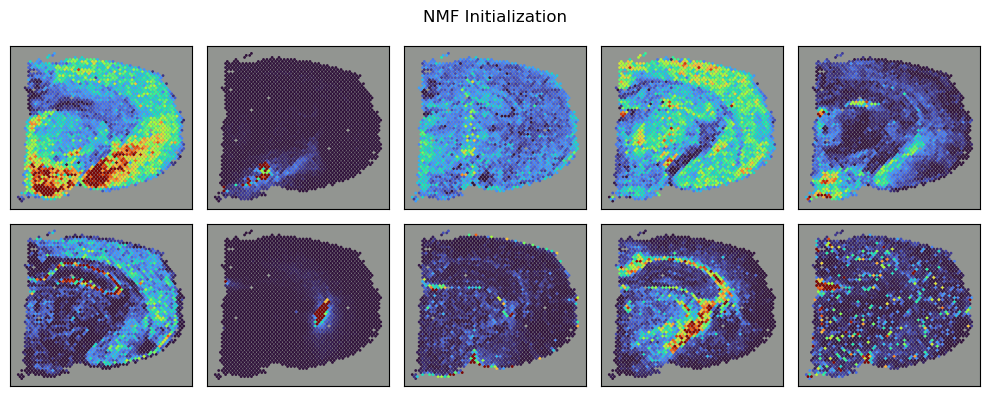

In [14]:
#size=2
#fig, axes = plt.subplots(2, 5, figsize=(size*5, size*1), tight_layout=True)
fig = plot_factors(np.exp(factors_ordered).T, X, moran_idx=moran_idx, size=2, s=1, alpha=1.0)
fig.suptitle("NMF Initialization")
#fig.set_figheight(6)
#fig.savefig(f"{save_path}_L=15_nmf_initialization.png")

In [15]:
headers = ['iterations', 'learning_rate', 'sigma', 'lengthscale', 'time', 'K', 'rmse_loss']

In [16]:
csv_path = path.join(save_path, 'visium_nsf_csv_results.csv')

In [ ]:
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [18]:
def run_experiment(X, Y, save_path, NMF=True, batched=True):
    # Define the parameter grid
    param_grid = {
        'sigma': [0.1],
        'lengthscale': [0.07],
        'learning_rate': [1e-3],
        'iterations': [1000],
        'L': [10],
        'M': [50, 1000, 2000] #len(X)],
        #'K': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000]
    }
   
                
    with open(csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
    
        # Iterate over each parameter combination
        for params in ParameterGrid(param_grid):
            final_time = 0.0
            dicts = {
                    'L': params['L'], 
                    'M': len(X), # use total number of inducing points
                    'sigma': params['sigma'], 
                    'lengthscale': params['lengthscale'], 
                    'jtr': 1e-1, # no lower
                    'batch_size': 128,
                    'lr': params['learning_rate'],
                    'rs': 256,
                    'lkzz_build': 1,
                    'model': 'SVGP',
                    'L1_jitter': 1e-1, # no lower
                    'iterations': params['iterations'],
                }
            kwargs = dicts
            # load in factors and loadings
            nmf_save_path = path.join(root_path, 'results/visium/nmf/')
            factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L={kwargs['L']}.npy")
            loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L={kwargs['L']}.npy")
            factors = np.load(factors_path)
            loadings = np.load(loadings_path)
    
    
            file_path = kwargs['model']
            if kwargs['model'] == 'VNNGP':
                file_path += f"_K={kwargs['K']}"
                if kwargs['lkzz_build']:
                    file_path += f"_lkzz={kwargs['lkzz_build']}"
            file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_ls={kwargs['lengthscale']}_sigma={kwargs['sigma']}"

            X_array = None
            Y_array = None
            
            if batched:
                file_path += f"_bs={kwargs['batch_size']}"
            
            if NMF:
                file_path += f"_NMFinit"
                X_array = np.array(X)
                Y_array = np.array(Y)
                moran_idx, moranI = putil.dims_autocorr(factors, X_array)
                factors = factors[:, moran_idx]
                loadings = loadings[:, moran_idx]

            # check of model and its state dictionary already exist
            model_state_path = f'{save_path}/{file_path}_state_dict.pth'
            model_info_path = f'{save_path}/{file_path}_model.pt'

            if path.exists(model_state_path) and path.exists(model_info_path):
                print(f"Loading existing model from {model_state_path} and continuing training.")
                model = putil.build_model_hybrid(X_array, Y_array, loadings=loadings, factors=factors, kwargs=kwargs)
                model.load_state_dict(torch.load(model_state_path))
                
                saved_info = torch.load(model_info_path)
                losses = saved_info.get('losses', [])
                means = saved_info.get('means', [])
                scales = saved_info.get('scales', [])
                final_time = saved_info.get('time', 0)
            else:
                print(f"Training a new model and saving to {model_state_path}.")
                model = putil.build_model(X_array, Y_array, loadings=loadings, factors=factors, kwargs=kwargs)
                losses, means, scales, final_time = [], [], [], 0
    
            putil.model_grads(model)
            model.prior.jitter = kwargs['jtr']
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
            model.to(device)
            X_torch = torch.tensor(X).type(torch.float).to(device)
            Y_torch = torch.tensor(Y).type(torch.float).to(device)
    
            start_time = time.time()
            more_losses, more_means, more_scales = putil.train_batched(model, optimizer, X_torch, Y_torch, device, 
                                                                         steps=kwargs['iterations'], E=3, batch_size=kwargs['batch_size'],
                                                                         kwargs=kwargs)
            end_time = time.time()
            final_time += (end_time - start_time)

            # combine new and previous losses, means, scales
            losses.extend(more_losses)
            means.extend(more_means)
            scales.extend(more_scales)

            torch.save(model.state_dict(), model_state_path)
            torch.save({
                'losses': losses,
                'means': means,
                'scales': scales,
                'time': final_time
            }, model_info_path)
    
            with torch.no_grad():
                val_loss = putil.evaluate_model_hybrid(model, X, Y, device)
            
            mean_cv_loss = np.mean(val_loss)
            print(f'Params: {params}, Mean CV Loss: {mean_cv_loss}')
    
            #write the results to the CSV file
            writer.writerow([params['iterations'], params['learning_rate'], params['sigma'], params['lengthscale'], final_time, mean_cv_loss])
    
            fig1, ax1 = plt.subplots()
            ax1.plot(losses)
            fig1.suptitle(f"{kwargs['model']} Loss | sigma: {params['sigma']}, lengthscale: {params['lengthscale']}")
            fig1.savefig(f'{save_path}/{file_path}_loss.png')
            plt.show()
            plt.close()
    
            model.cpu()
            qF, _, _ = model.sf.prior(X.cpu(), kwargs=kwargs)
            mean = torch.exp(qF.mean).detach().numpy()
            
            fig2 = plot_factors(mean, X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=5, alpha=1, ax=None)
            fig2.suptitle("Visium NSF", size=15)
            fig2.set_figheight(2.25)
            fig2.tight_layout()
            fig2.savefig(f'{save_path}/{file_path}_plot.png')
            plt.show()
            plt.close()
            model.to(device)

In [19]:
run_experiment(X, Y.T, save_path)

Training a new model and saving to /engelhardt/home/pshrestha/vnngp/results/visium/nsf/SVGP_M=2688_L=10_lr=0.001_jtr=0.1_ls=0.07_sigma=0.1_bs=128_NMFinit_state_dict.pth.


  0%|          | 0/1000 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 276.00 MiB (GPU 0; 23.60 GiB total capacity; 2.38 GiB already allocated; 128.69 MiB free; 2.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
size=2
fig, axes = plt.subplots(3, 5, figsize=(size*5, size*3), tight_layout=True)
fig = plot_factors(mean, X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1, alpha=1, ax=axes)
fig.suptitle("Visium NSF", size=15)
#fig.set_figheight(4.25)
fig.tight_layout()
plt.show()

In [ ]:
model.cpu()
qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()

In [ ]:
fig = plot_factors(mean, X.cpu().detach().numpy(), moran_idx=None, size=2, s=5, alpha=1, ax=None)
fig.suptitle("GGblocks NSF", size=15)
fig.set_figheight(4.25)
fig.tight_layout()
plt.show()